# Técnica de nichos


![](https://images.slideplayer.com/26/8478406/slides/slide_3.jpg)
Fuente de la imagen: slideplayer

In [1]:
!pip install deap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from deap import base
from deap import creator
from deap import tools
from deap import tools
from deap import algorithms

import math


import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# This is the original elitism module.
def elitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


In [4]:

# problem constants:
DIMENSIONS = 2  # number of dimensions
BOUND_LOW, BOUND_UP = 0.0, 1.0  # boundaries for all dimensions

# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

# sharing constants:
DISTANCE_THRESHOLD = 0.1
SHARING_EXTENT = 1.0

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)


# helper function for creating random float numbers uniformaly distributed within a given range [low, up]
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(a, b) for a, b in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

# create an operator that randomly returns a float in the desired range and dimension:
toolbox.register("attr_float", randomFloat, BOUND_LOW, BOUND_UP)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attr_float)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# 'Inverted' Himmelblau function as the given individual's fitness:
def himmelblauInverted(individual):
    X = individual[0]
    Y = individual[1]
    n =2

    f = (16*X*(1 - X)*Y*(1 - Y)*np.sin(n*np.pi*X)*np.sin(n*np.pi*Y))**2
    return f,  # return a tuple

toolbox.register("evaluate", himmelblauInverted)

# wraps the tools.selTournament() with fitness sharing
# same signature as tools.selTournament()
def selTournamentWithSharing(individuals, k, tournsize, fit_attr="fitness"):

    # get orig fitnesses:
    origFitnesses = [ind.fitness.values[0] for ind in individuals]

    # apply sharing to each individual:
    for i in range(len(individuals)):
        sharingSum = 1

        # iterate over all other individuals
        for j in range(len(individuals)):
            if i != j:
                # calculate eucledean distance between individuals:
                distance = math.sqrt(
                    ((individuals[i][0] - individuals[j][0]) ** 2) + ((individuals[i][1] - individuals[j][1]) ** 2))

                if distance < DISTANCE_THRESHOLD:
                    sharingSum += (1 - distance / (SHARING_EXTENT * DISTANCE_THRESHOLD))

        # reduce fitness accordingly:
        individuals[i].fitness.values = origFitnesses[i] / sharingSum,

    # apply original tools.selTournament() using modified fitness:
    selected = tools.selTournament(individuals, k, tournsize, fit_attr)

    # retrieve original fitness:
    for i, ind in enumerate(individuals):
        ind.fitness.values = origFitnesses[i],

    return selected


In [5]:
# genetic operators:
toolbox.register("select", selTournamentWithSharing, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

In [6]:
# Genetic Algorithm flow:

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with elitism:
population, logbook = elitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)


gen	nevals	max     	avg      
0  	300   	0.400606	0.0796881
1  	256   	0.405923	0.150508 
2  	261   	0.405923	0.23521  
3  	260   	0.407347	0.25361  
4  	257   	0.407347	0.250685 
5  	254   	0.407347	0.260656 
6  	255   	0.407575	0.258911 
7  	258   	0.407575	0.249949 
8  	254   	0.407575	0.254691 
9  	258   	0.407575	0.252444 
10 	251   	0.407575	0.258135 
11 	254   	0.407575	0.258485 
12 	259   	0.407575	0.249236 
13 	254   	0.407575	0.254652 
14 	248   	0.407575	0.263352 
15 	258   	0.407575	0.255232 
16 	258   	0.407575	0.257398 
17 	259   	0.407575	0.256084 
18 	261   	0.407575	0.258888 
19 	256   	0.407575	0.242073 
20 	253   	0.407575	0.254896 
21 	261   	0.407584	0.247793 
22 	261   	0.407584	0.24976  
23 	257   	0.407584	0.255019 
24 	256   	0.407584	0.265855 
25 	255   	0.407593	0.256851 
26 	253   	0.407593	0.244294 
27 	257   	0.407593	0.262339 
28 	256   	0.407593	0.253733 
29 	261   	0.407593	0.257853 
30 	254   	0.407593	0.246234 
31 	249   	0.407593	0.251052 
32 	257   

274	254   	0.407595	0.23912  
275	265   	0.407595	0.243679 
276	260   	0.407595	0.248375 
277	254   	0.407595	0.251456 
278	260   	0.407595	0.26341  
279	252   	0.407595	0.259086 
280	250   	0.407595	0.255119 
281	255   	0.407595	0.248841 
282	255   	0.407595	0.251536 
283	261   	0.407595	0.250452 
284	262   	0.407595	0.258726 
285	261   	0.407595	0.249557 
286	258   	0.407595	0.247861 
287	259   	0.407595	0.248518 
288	263   	0.407595	0.260018 
289	260   	0.407595	0.254969 
290	253   	0.407595	0.254186 
291	251   	0.407595	0.248414 
292	256   	0.407595	0.25446  
293	252   	0.407595	0.252369 
294	257   	0.407595	0.246509 
295	263   	0.407595	0.248467 
296	257   	0.407595	0.255226 
297	261   	0.407595	0.258032 
298	251   	0.407595	0.259626 
299	262   	0.407595	0.25837  
300	255   	0.407595	0.245033 


In [7]:
# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- Best Fitness = ", best.fitness.values[0])

-- Best Individual =  [0.7024171412284685, 0.2975839017935295]
-- Best Fitness =  0.40759508340739364


In [8]:
print("- Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

- Best solutions are:
0 :  0.40759508340739364  ->  [0.7024171412284685, 0.2975839017935295]
1 :  0.4075950666185308  ->  [0.29756013929420727, 0.2975795691178183]
2 :  0.40759506155195685  ->  [0.29761725667526134, 0.7024079408828847]
3 :  0.4075950561930614  ->  [0.7023790054814535, 0.2975909767511874]
4 :  0.4075950526719207  ->  [0.29761725667526134, 0.702393025491524]
5 :  0.40759504535263424  ->  [0.2975864909376928, 0.2976274955306136]
6 :  0.4075950333754733  ->  [0.29756380557132783, 0.2976274955306136]
7 :  0.4075950308089493  ->  [0.2975614816326083, 0.2976274955306136]
8 :  0.4075950291460851  ->  [0.2975600844428956, 0.2976274955306136]
9 :  0.4075950247099951  ->  [0.29756013929420727, 0.2975433841115379]
10 :  0.40759502457725355  ->  [0.29756013929420727, 0.29754331753052093]
11 :  0.40759501921014235  ->  [0.29763928008576745, 0.2975809902918442]
12 :  0.407595017069558  ->  [0.29756013929420727, 0.2975397053965461]
13 :  0.4075950101897502  ->  [0.2975614816326083, 0.

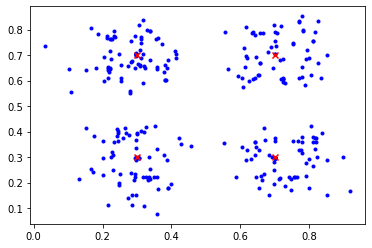

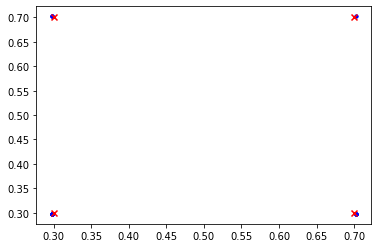

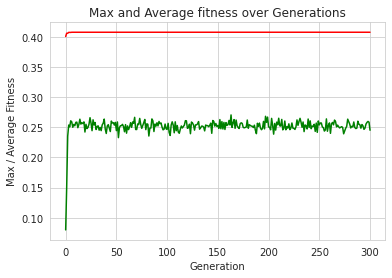

In [9]:

# plot solution locations on x-y plane:
plt.figure(1)
globalMaxima = [[0.3, 0.3], [0.7, 0.3], [0.3, 0.7], [0.7, 0.7]]
plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
plt.scatter(*zip(*population), marker='.', color='blue', zorder=0)    # plot solution locations on x-y plane:
plt.savefig("nichos1.jpg")

# plot best solutions locations on x-y plane:
plt.figure(2)
plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
plt.scatter(*zip(*hof.items), marker='.', color='blue', zorder=0)
plt.savefig("nichos2.jpg")

# extract statistics:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

# plot statistics:
plt.figure(3)
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.savefig("nichos3.jpg")

plt.show()
